In [9]:
#pip install tensorflow

  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/e5/50/00dba77925bf2a0a1e45d7bcf8a69a1d2534fb4bb277d9010bd148d2235e/tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tf-keras>=2.14.1 from https://files.pythonhosted.org/packages/75/aa/cf09f8956d4f276f655b13674e15d8d6015fd832f9689aa9ff2a515781ab/tf_keras-2.16.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---- ----------------------------------- 0.2/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 10.0 MB/s eta 0:00:00


In [15]:
import numpy as np
import pandas as pd
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import CoherenceModel
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Load your DataFrame with text data
df = pd.read_csv('sectionized_data.csv')

# Preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to each document in df['Body']
processed_docs = df['Body'].apply(preprocess_text)

# Create TaggedDocument for training the Doc2Vec model
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(processed_docs)]

# Train Doc2Vec model
doc2vec_model = gensim.models.Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Extract document embeddings
document_embeddings = [doc2vec_model.docvecs[str(i)] for i in range(len(tagged_data))]

# Convert document embeddings to GloVe-like format
document_vectors = np.array(document_embeddings)

# Define the NTM-GloVe model using TensorFlow
class NTM_GloVe_TensorFlow:
    def __init__(self, num_topics):
        self.num_topics = num_topics
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(512, activation='relu', input_shape=(100,)),
            Dense(self.num_topics, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32)

    def transform(self, X):
        return self.model.predict(X)

# Function to compute coherence score for a given number of topics
def compute_coherence_score(num_topics, document_vectors):
    # Convert document embeddings to one-hot encodings (for topics)
    document_vectors_onehot = np.eye(num_topics)[np.random.choice(num_topics, document_vectors.shape[0])]
    
    # Train NTM-GloVe model
    ntm_glove_tf_model = NTM_GloVe_TensorFlow(num_topics)
    ntm_glove_tf_model.fit(document_vectors, document_vectors_onehot)
    
    # Get the topic distributions for each document
    document_topic_distributions = ntm_glove_tf_model.transform(document_vectors)
    
    # Convert document_topic_distributions to topic vectors
    topic_vectors = np.argmax(document_topic_distributions, axis=1)
    
    # Convert topic vectors to topic distribution matrix
    topic_distribution_matrix = np.eye(num_topics)[topic_vectors]
    
    # Convert topic_distribution_matrix to a list of topic lists
    topic_lists = topic_distribution_matrix.tolist()
    
    # Create a dictionary for the coherence model
    dictionary = gensim.corpora.Dictionary(processed_docs)
    
    # Compute coherence score
    coherence_model = CoherenceModel(topics=topic_lists, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

# Range of possible numbers of topics to explore
min_topics = 2
max_topics = 100

# List to store coherence scores
coherence_scores = []

# Iterate over the range of topic numbers and compute coherence scores
for num_topics in range(min_topics, max_topics + 1):
    coherence_score = compute_coherence_score(num_topics, document_vectors)
    coherence_scores.append(coherence_score)

# Find the optimal number of topics based on the maximum coherence score
optimal_num_topics = min_topics + coherence_scores.index(max(coherence_scores))

print("Optimal number of topics:", optimal_num_topics)

# Convert document embeddings to one-hot encodings (for topics)
document_vectors_onehot = np.eye(optimal_num_topics)[np.random.choice(optimal_num_topics, document_vectors.shape[0])]

# Train NTM-GloVe model with optimal number of topics
ntm_glove_tf_model = NTM_GloVe_TensorFlow(optimal_num_topics)
ntm_glove_tf_model.fit(document_vectors, document_vectors_onehot)

# Get the topic distributions for each document
document_topic_distributions = ntm_glove_tf_model.transform(document_vectors)

# Print topic distributions for all documents
for i, doc_topic_distribution in enumerate(document_topic_distributions):
    print(f"Topic Distribution for Document {i + 1}:")
    print(doc_topic_distribution)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jositav.2020/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jositav.2020/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\jositav.2020\AppData\Local\Temp\ipykernel_34608\919224592.py:44: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  document_embeddings = [doc2vec_model.docvecs[str(i)] for i in range(len(tagged_data))]
C:\Users\jositav.2020\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8656
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.7353
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7312
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.6451
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.6092
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.6188
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.6108
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.5811
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.5567
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.5525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.1308
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.1280
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.0106
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.9761
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss:

Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.5837
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.5515
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.5347
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.5117
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.4892
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.4700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.3376
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.0047
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 1.8955
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.8310
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.7695
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.7203
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.6807
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.6456
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.61

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.4966
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.3474
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.2764
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2.2344
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.2100
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.1767
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.1406
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.1141
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.0956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3.2420
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.7687
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.4420
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.2467
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.1433
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.0781
Epoch 7/10


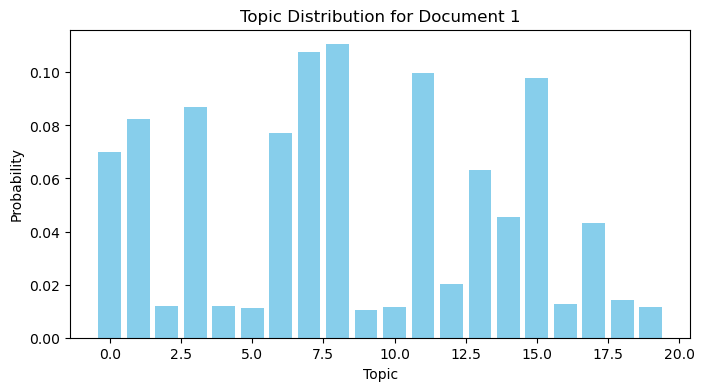

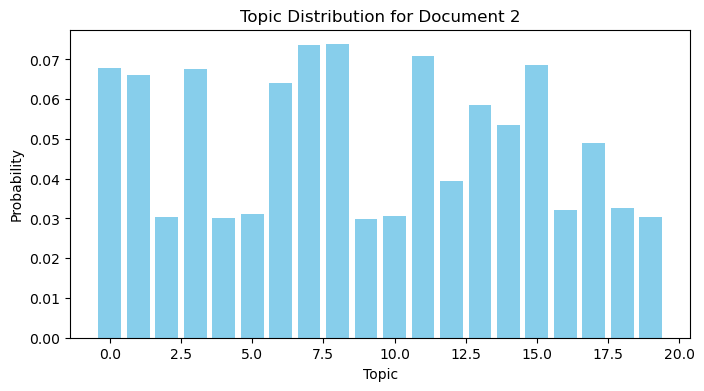

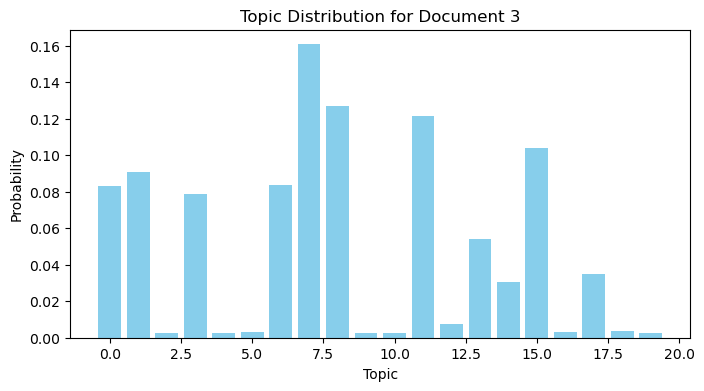

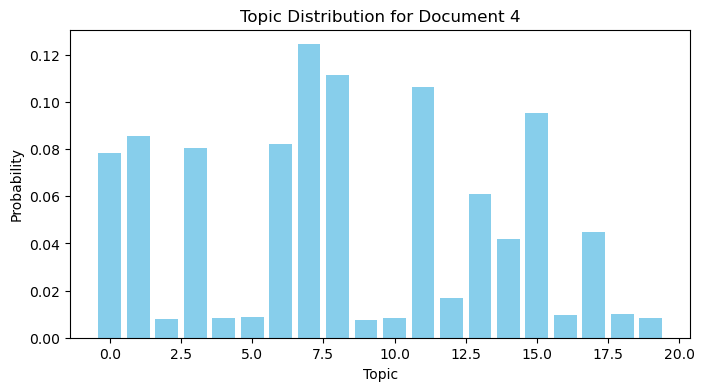

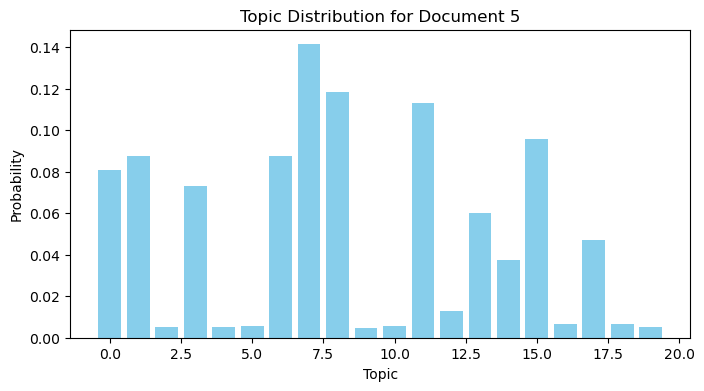

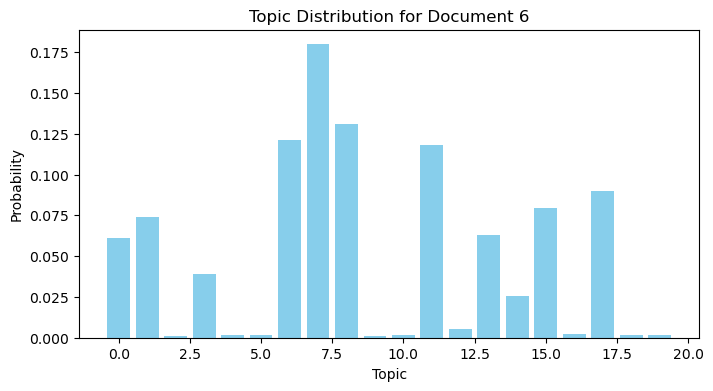

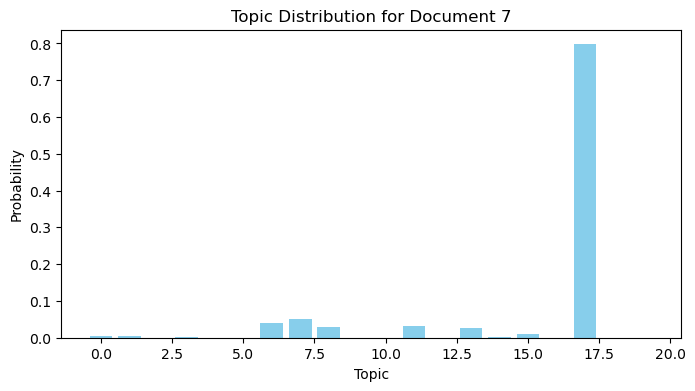

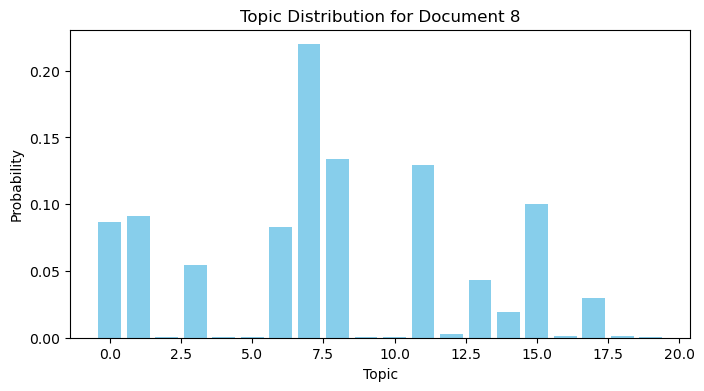

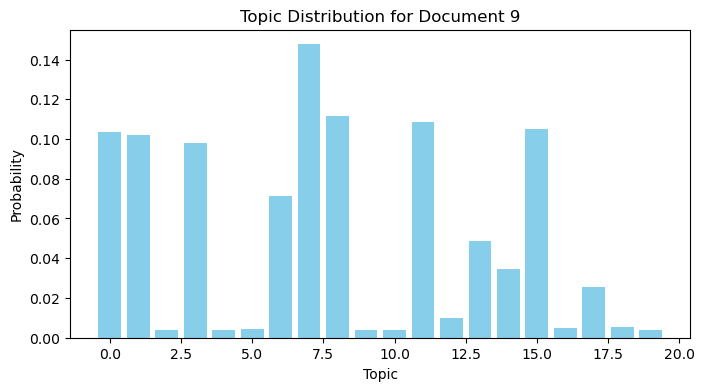

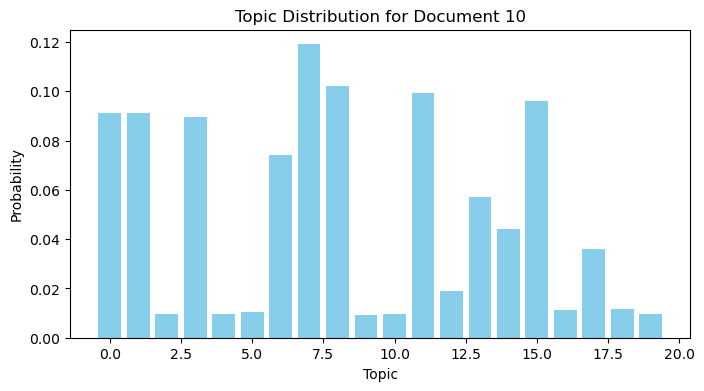

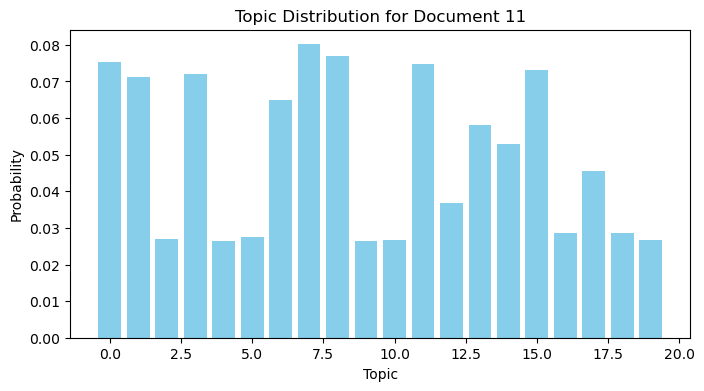

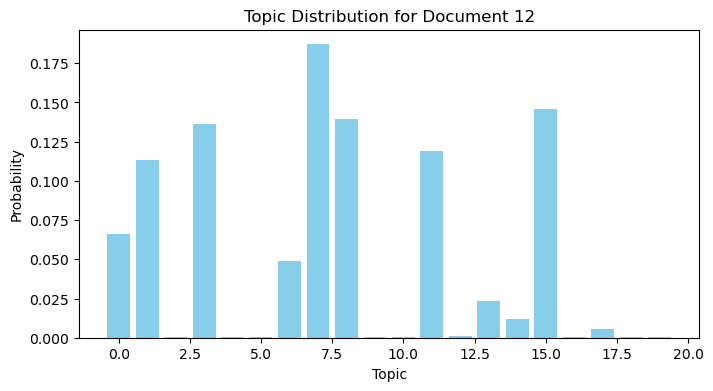

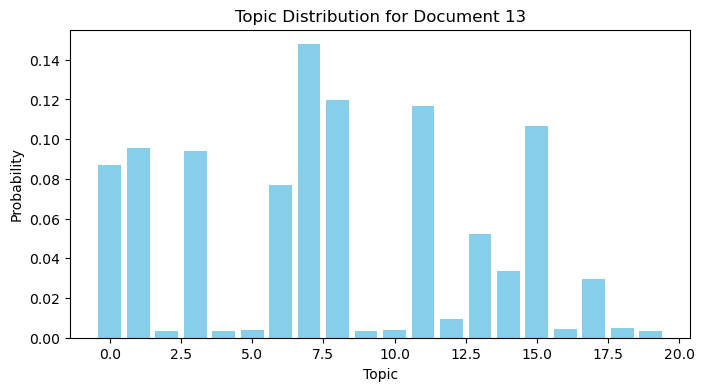

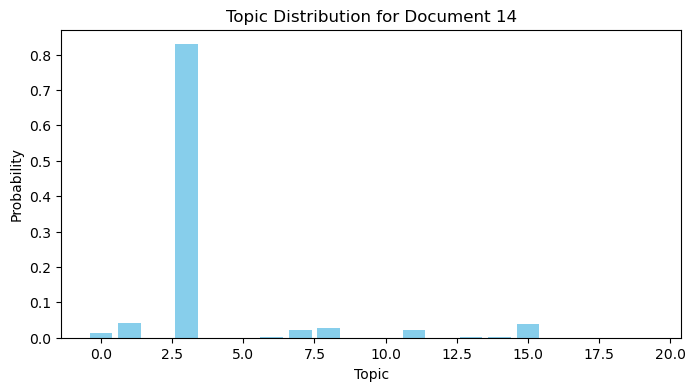

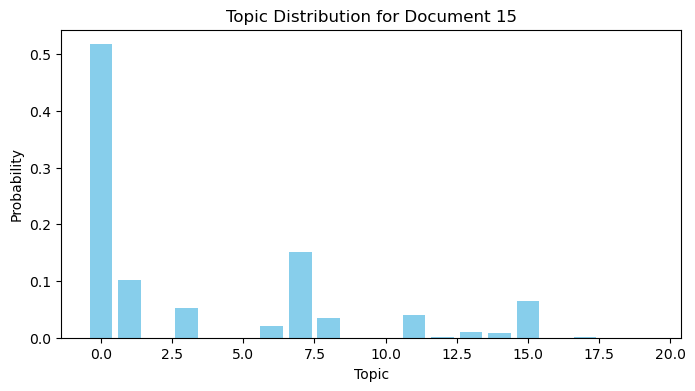

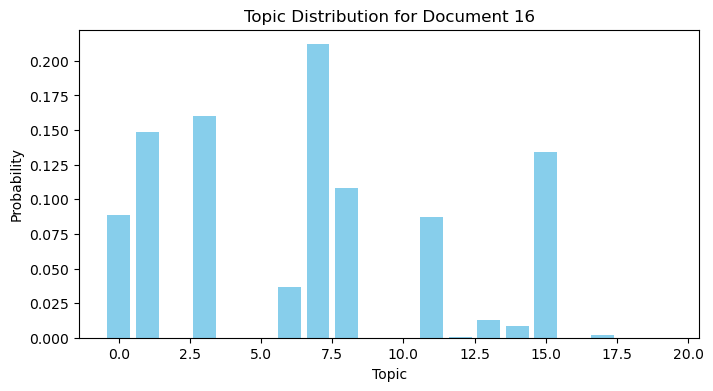

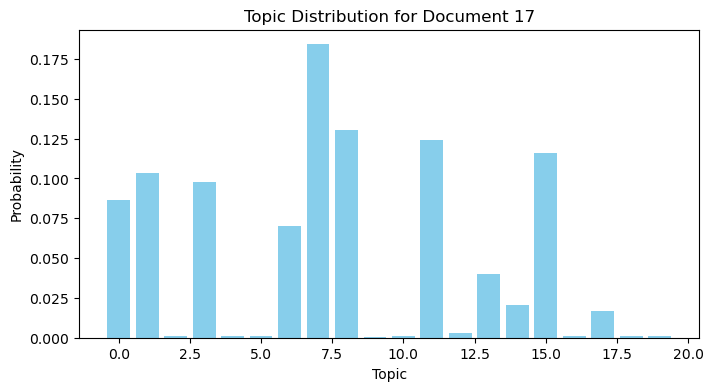

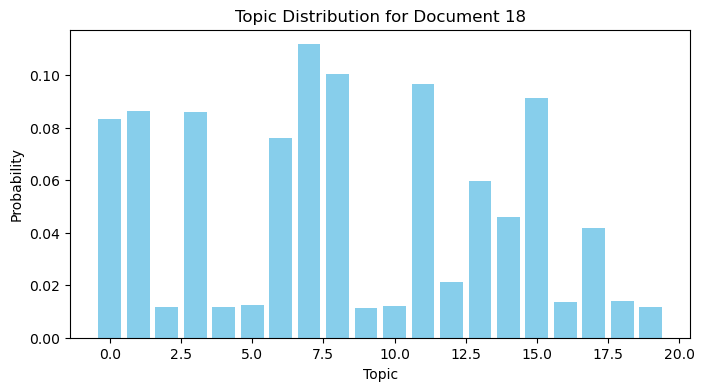

In [16]:
import matplotlib.pyplot as plt

# Plot topic distributions for all documents
for i, doc_topic_distribution in enumerate(document_topic_distributions):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(doc_topic_distribution)), doc_topic_distribution, color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel('Probability')
    plt.title(f'Topic Distribution for Document {i + 1}')
    plt.show()


In [24]:
# Define a function to calculate coherence score
def calculate_coherence_score(model, documents, dictionary, coherence='c_v'):
    # Get the topics
    topics = model.model.get_weights()[0]  # Assuming the topic weights are in the first layer
    
    # Convert topic weights to token IDs
    topic_token_ids = []
    for topic_weights in topics:
        topic_token_ids.append([token_id for token_id, weight in sorted(dictionary.token2id.items(), key=lambda x: x[1])])

    # Compute coherence score
    coherence_model = CoherenceModel(topics=topic_token_ids, texts=documents, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

# Create a Gensim Dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)

# Calculate coherence score
coherence_score = calculate_coherence_score(ntm_glove_tf_model, processed_docs, dictionary)
print("Coherence Score:", coherence_score)



Coherence Score: 0.31322857195832077


In [25]:
# Initialize a list to store dominant topics
dominant_topics = []

# Iterate through the document topic distributions
for doc_topic_distribution in document_topic_distributions:
    # Find the index of the topic with the highest probability
    dominant_topic_index = np.argmax(doc_topic_distribution)
    # Append the dominant topic index to the list
    dominant_topics.append(dominant_topic_index)

# Print the dominant topics for each document
for i, dominant_topic in enumerate(dominant_topics):
    print(f"Document {i + 1}: Dominant Topic {dominant_topic}")

Document 1: Dominant Topic 8
Document 2: Dominant Topic 8
Document 3: Dominant Topic 7
Document 4: Dominant Topic 7
Document 5: Dominant Topic 7
Document 6: Dominant Topic 7
Document 7: Dominant Topic 17
Document 8: Dominant Topic 7
Document 9: Dominant Topic 7
Document 10: Dominant Topic 7
Document 11: Dominant Topic 7
Document 12: Dominant Topic 7
Document 13: Dominant Topic 7
Document 14: Dominant Topic 3
Document 15: Dominant Topic 0
Document 16: Dominant Topic 7
Document 17: Dominant Topic 7
Document 18: Dominant Topic 7
